# <u> Stock Price Prediction Analysis </u>


### Import libraries


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping

### Configuration


In [21]:
TICKER = 'WIPRO.NS'
TIME_STEPS = 10
EPOCHS = 50
BATCH_SIZE = 32

---


### 1. Data Collection and Exploration


In [ ]:
def fetch_stock_data(stock_symbol, start_date, end_date):
    data = yf.download(stock_symbol, start=start_date,
                       end=end_date, auto_adjust=True)
    return data

Fetch historical data


In [24]:
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = '2010-01-01'  # Using long-term data as in your original implementation

print(f"Fetching data for {TICKER} from {start_date} to {end_date}...")
wipro_data = fetch_stock_data(TICKER, start_date, end_date)
print(f"Retrieved {len(wipro_data)} trading days of data")

Fetching data for WIPRO.NS from 2010-01-01 to 2025-05-06...


[*********************100%***********************]  1 of 1 completed

Retrieved 3783 trading days of data


Display last 5 rows


In [25]:
wipro_data.tail()

Price,Close,High,Low,Open,Volume
Ticker,WIPRO.NS,WIPRO.NS,WIPRO.NS,WIPRO.NS,WIPRO.NS
Date,,,,,
2025-04-28,240.500000,241.949997,238.750000,240.500000,14218414
2025-04-29,241.399994,243.600006,239.850006,241.600006,16647246
2025-04-30,241.500000,243.399994,239.199997,241.550003,14206640
2025-05-02,241.679993,245.800003,240.750000,242.039993,10822257
2025-05-05,243.570007,246.869995,242.699997,244.000000,12170446


---


### 2. Data Visualization


Plot closing price history


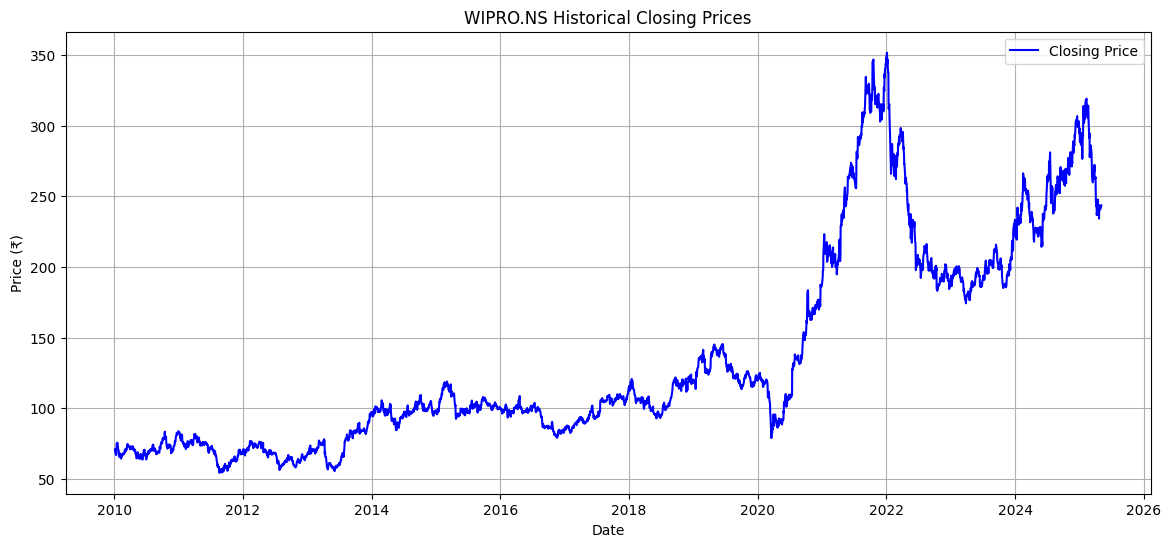

In [26]:
plt.figure(figsize=(14, 6))
plt.plot(wipro_data['Close'], label='Closing Price', color='blue')
plt.title(f'{TICKER} Historical Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price (₹)')
plt.grid(True)
plt.legend()
plt.show()

Plot volume and closing price on twin axes


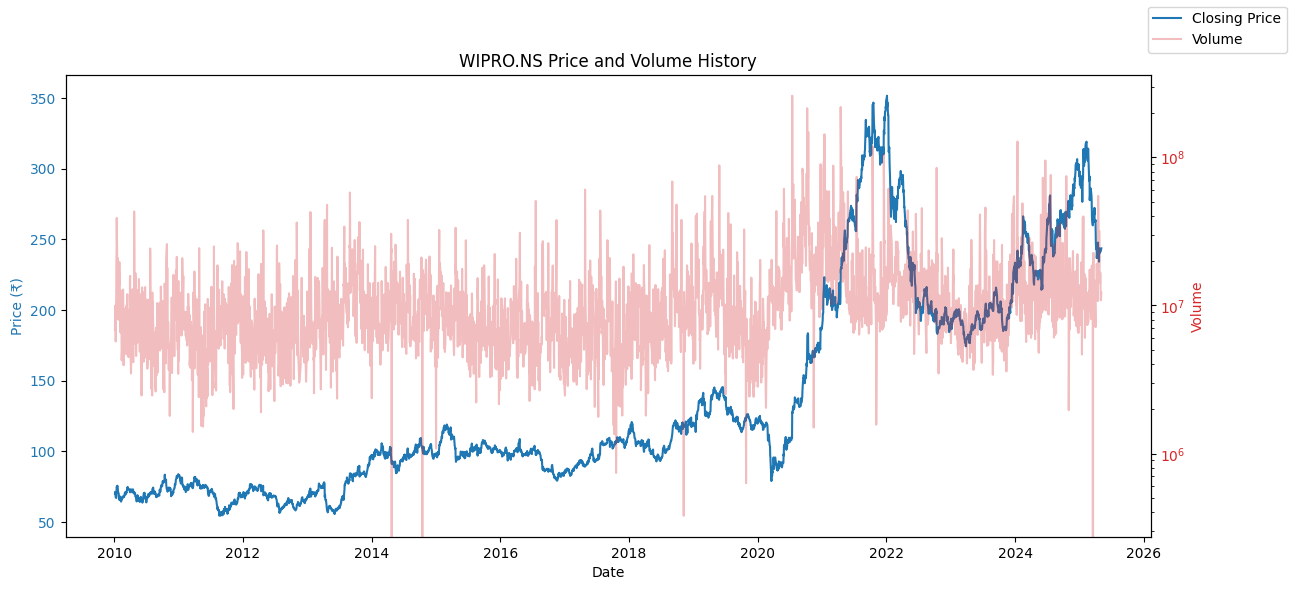

In [32]:
fig, ax1 = plt.subplots(figsize=(14, 6))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (₹)', color=color)
ax1.plot(wipro_data['Close'], color=color, label='Closing Price')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Volume', color=color)
ax2.plot(wipro_data['Volume'], color=color, alpha=0.3, label='Volume')
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_yscale('log')

plt.title(f'{TICKER} Price and Volume History')
fig.legend(loc="upper right")
plt.show()

---


### 3. Feature Engineering


Calculate moving averages


In [33]:
wipro_data['SMA_10'] = wipro_data['Close'].rolling(window=10).mean()
wipro_data['SMA_50'] = wipro_data['Close'].rolling(window=50).mean()
wipro_data.dropna(inplace=True)

Plot moving averages


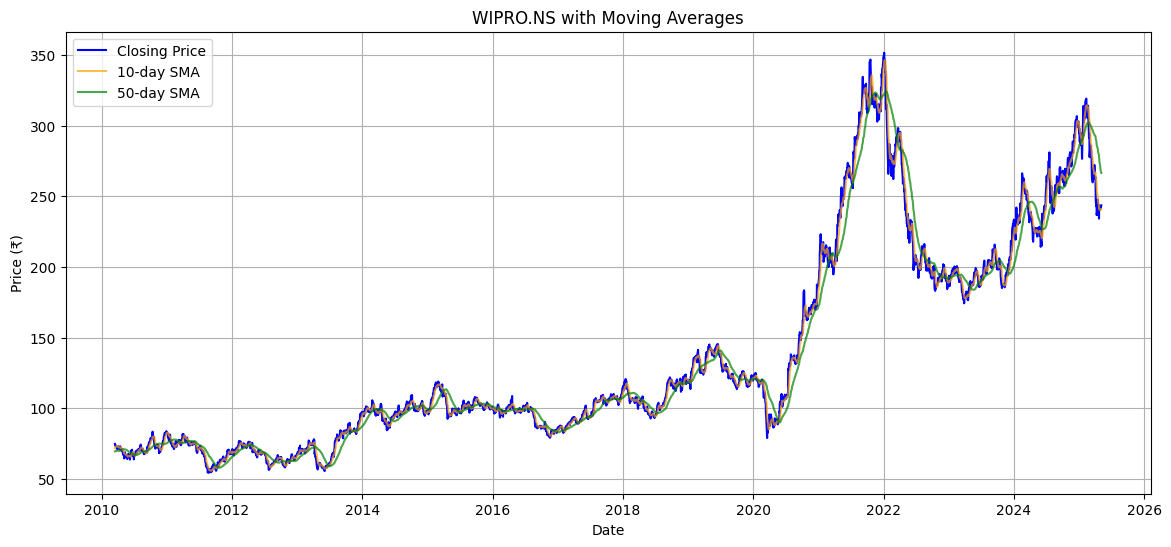

In [34]:
plt.figure(figsize=(14, 6))
plt.plot(wipro_data['Close'], label='Closing Price', color='blue')
plt.plot(wipro_data['SMA_10'], label='10-day SMA', color='orange', alpha=0.7)
plt.plot(wipro_data['SMA_50'], label='50-day SMA', color='green', alpha=0.7)
plt.title(f'{TICKER} with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (₹)')
plt.grid(True)
plt.legend()
plt.show()

---


### 4. Data Preprocessing


In [ ]:
def preprocess_data(data, time_step=TIME_STEPS):
    # Scale features
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(
        data[['Close', 'SMA_10', 'SMA_50', 'Volume']])

    # Create sequences for LSTM
    X, y = [], []
    for i in range(len(scaled_data) - time_step - 1):
        X.append(scaled_data[i:(i + time_step), :])  # All features
        y.append(scaled_data[i + time_step, 0])  # Only 'Close' price as target
    X, y = np.array(X), np.array(y)

    # Train-test split (80-20 as in your code)
    split = int(len(X) * 0.8)
    X_train, X_test = X[:split], X[split:]
    y_train, y_test = y[:split], y[split:]

    return X_train, y_train, X_test, y_test, scaler

Preprocess the data


In [39]:
X_train, y_train, X_test, y_test, scaler = preprocess_data(wipro_data)

print(f"Training sequences: {X_train.shape[0]}")
print(f"Testing sequences: {X_test.shape[0]}")

Training sequences: 2978
Testing sequences: 745


---


### 5. Model Building


In [ ]:
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

Build model


In [41]:
model = build_lstm_model((X_train.shape[1], X_train.shape[2]))
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 32,501 (126.96 KB)

 Trainable params: 32,501 (126.96 KB)

 Non-trainable params: 0 (0.00 B)

---


### 6. Model Training


In [ ]:
early_stopping = EarlyStopping(
    monitor='loss', patience=5, restore_best_weights=True)
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - loss: 0.0157
Epoch 2/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.5739e-04
Epoch 3/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 4.5635e-04
Epoch 4/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.3407e-04
Epoch 5/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 3.9067e-04
Epoch 6/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.8869e-04
Epoch 7/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 3.0436e-04
Epoch 8/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 3.5315e-04
Epoch 9/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 2.9004e-04
Epoch 10/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - loss: 2.5331e-04
Epoch 11/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 4.1607e-04
Epoch 12/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.0177e-04
Epoch 13/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.6877e-04
Epoch 14/50
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8388e-04
Epoch 15/50
94/94 ━

Plot training loss


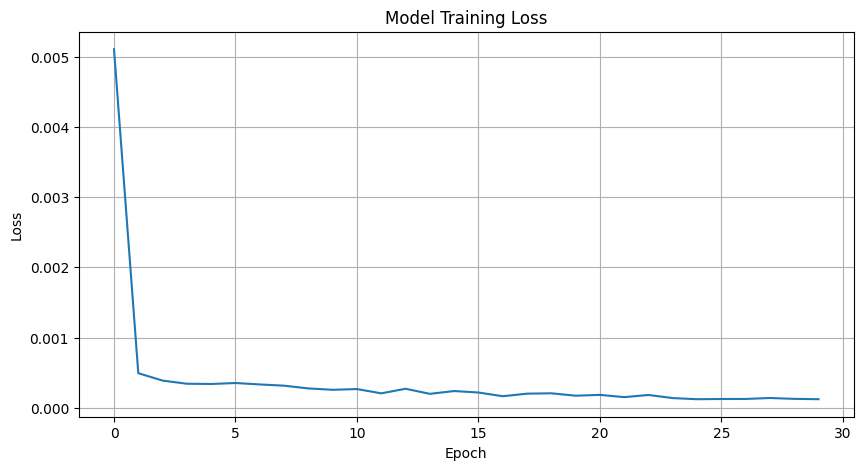

In [43]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.title('Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

---


### 7. Model Evaluation


Create test predictions for visualization


In [44]:
test_predict = model.predict(X_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


Rescale predictions


In [45]:
test_predict = scaler.inverse_transform(
    np.concatenate([test_predict, np.zeros((len(test_predict), 3))], axis=1)
)[:, 0]
y_test_actual = scaler.inverse_transform(
    np.concatenate([y_test.reshape(-1, 1), np.zeros((len(y_test), 3))], axis=1)
)[:, 0]

Plot actual vs predicted


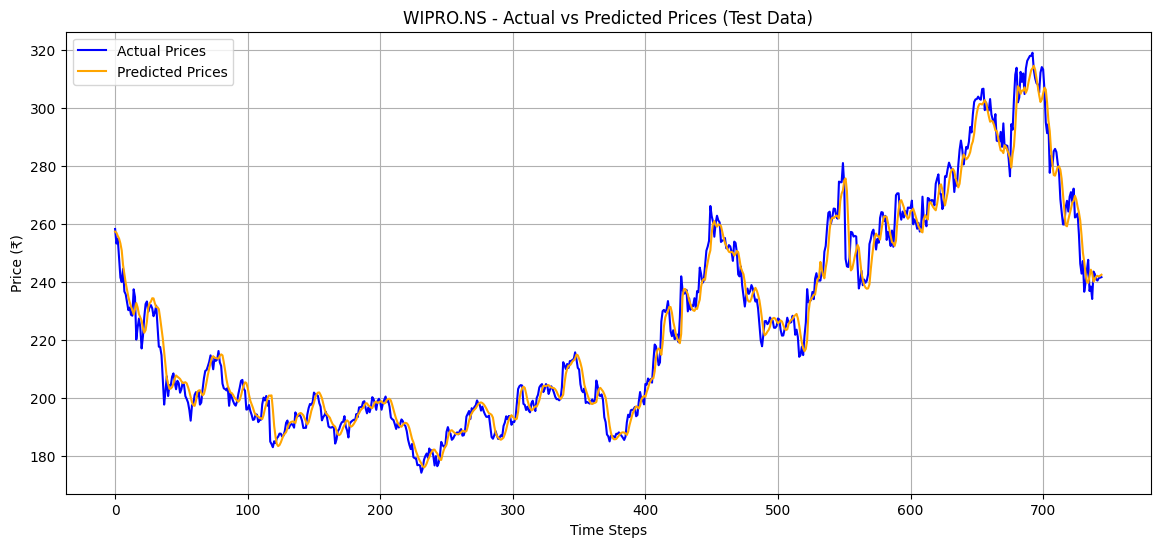

In [46]:
plt.figure(figsize=(14, 6))
plt.plot(y_test_actual, label='Actual Prices', color='blue')
plt.plot(test_predict, label='Predicted Prices', color='orange')
plt.title(f'{TICKER} - Actual vs Predicted Prices (Test Data)')
plt.xlabel('Time Steps')
plt.ylabel('Price (₹)')
plt.legend()
plt.grid(True)
plt.show()

---


### 8. Next Day Prediction


Prepare last sequence for prediction


In [ ]:
last_sequence = scaler.transform(
    wipro_data[['Close', 'SMA_10', 'SMA_50', 'Volume']].tail(TIME_STEPS)
)
last_sequence = np.reshape(
    last_sequence, (1, TIME_STEPS, last_sequence.shape[1]))

Make prediction


In [48]:
predicted_scaled = model.predict(last_sequence)
predicted_price = scaler.inverse_transform(
    np.concatenate([predicted_scaled, np.zeros((1, 3))], axis=1)
)[0, 0]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


Display prediction


In [50]:
print(f"Next day predicted closing price for {TICKER}: ₹{predicted_price:.2f}")

Next day predicted closing price for WIPRO.NS: ₹243.36


Compare with recent prices


In [51]:
print("Recent closing prices:")
print(wipro_data['Close'].tail(5))

Recent closing prices:
Ticker        WIPRO.NS
Date                  
2025-04-28  240.500000
2025-04-29  241.399994
2025-04-30  241.500000
2025-05-02  241.679993
2025-05-05  243.570007
